In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [5]:
import os
import pandas as pd

# Path to the directory containing the image files
#change the path
directory ='C://Users/gauth/OneDrive/Desktop/DIP Project/g4'

# List to store extracted information
data = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    # Split filename by ".chip" to get the main part
    main_part = filename.split(".chip")[0]

    # Split main part by "_" to extract age and gender
    age, gender, *rest = main_part.split("_")

    # Convert gender to string representation
    gender = "Male" if gender == "0" else "Female"

    # Join the rest of the filename back together (if any)
    rest = "_".join(rest)

    # Append extracted information to the list
    data.append({'Filename': filename, 'Age': int(age), 'Gender': gender})

# Create DataFrame from the extracted information
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                                              Filename  Age  Gender
0    10_0_0_20170110225505288.jpg.chip - Copy - Cop...   10    Male
1    10_0_0_20170110225601897.jpg.chip - Copy - Cop...   10    Male
2    10_0_0_20170116201337172.jpg.chip - Copy - Cop...   10    Male
3    10_0_0_20170117135444407.jpg.chip - Copy - Cop...   10    Male
4               116_1_2_20170112220255503.jpg.chip.jpg  116  Female
..                                                 ...  ...     ...
490  7_0_0_20170110215620675.jpg.chip - Copy - Copy...    7    Male
491  7_0_0_20170110215633251.jpg.chip - Copy - Copy...    7    Male
492              85_1_0_20170110182128680.jpg.chip.jpg   85  Female
493              96_1_2_20170110182504813.jpg.chip.jpg   96  Female
494              96_1_2_20170110182526540.jpg.chip.jpg   96  Female

[495 rows x 3 columns]


In [6]:
import numpy as np
import cv2
import os
from ultralytics import YOLO  # Importing YOLO model for face detection


# Loading caffe models for age and gender prediction
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

ageNet = cv2.dnn.readNet(ageModel, ageProto)  # Loading age prediction model
genderNet = cv2.dnn.readNet(genderModel, genderProto)  # Loading gender prediction model

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Path for images
folder_path = 'C://Users/gauth/OneDrive/Desktop/DIP PROJECT/g4'

# List all image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

# Number of images
print(len(image_files))

# Initialize an empty list to store results
result_list = []

# Initialize YOLO model for face detection
model = YOLO("yolov8n-face.pt")

# Iterate over each image
for image_file in image_files:
    # Read image
    img = cv2.imread(image_file)
    
    # Detect faces using YOLO model
    results = model(img)
    result_list.append(results)
    boxes = results[0].boxes

    # Loop over the detected faces
    for box in boxes:
        # Extract coordinates of the bounding box
        top_left_x = int(box.xyxy.tolist()[0][0])
        top_left_y = int(box.xyxy.tolist()[0][1])
        bottom_right_x = int(box.xyxy.tolist()[0][2])
        bottom_right_y = int(box.xyxy.tolist()[0][3])

        # Draw rectangle around the detected face
        cv2.rectangle(img, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (255, 0, 0), 2)
        
        # Extract the detected face region
        detected_face = img[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        
        #Bicubic interpolation
        detected_face=cv2.resize(detected_face, (227, 227), interpolation=cv2.INTER_CUBIC)

        # Preprocess the detected face with blob
        detected_face_blob = cv2.dnn.blobFromImage(detected_face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        # Input the preprocessed face into gender prediction model
        genderNet.setInput(detected_face_blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        # Input the preprocessed face into age prediction model
        ageNet.setInput(detected_face_blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        print("gender", gender, "age", age)

        label = "{}{}".format(gender, age)

        # Draw predicted gender and age on the image
        cv2.putText(img, label, (top_left_x + 20, top_left_y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1,
                    cv2.LINE_AA)

        # Loading predicted results to the existing dataframe (df)
        # Note: You need to define and initialize the dataframe (df) somewhere in your code
        df.loc[df['Filename'] == os.path.basename(image_file), 'Predicted_Gender'] = gender
        df.loc[df['Filename'] == os.path.basename(image_file), 'Predicted_Age'] = age

    # Show the image with predicted results
    #cv2.imshow("ok", img)
    cv2.waitKey(0)

# Close all OpenCV windows
cv2.destroyAllWindows()


495

0: 448x640 1 face, 207.1ms
Speed: 16.8ms preprocess, 207.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (4-6)

0: 448x640 1 face, 249.4ms
Speed: 8.1ms preprocess, 249.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (4-6)

0: 448x640 1 face, 222.8ms
Speed: 8.6ms preprocess, 222.8ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (38-43)

0: 448x640 2 faces, 207.4ms
Speed: 9.0ms preprocess, 207.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Female age (25-32)

0: 448x640 1 face, 192.4ms
Speed: 8.7ms preprocess, 192.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (8-12)

0: 448x640 2 faces, 175.3ms
Speed: 0.0ms preprocess, 175.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Male age (4-6)

0: 448x640 1 face, 257.5ms
Speed: 0.3ms preproces

In [7]:
# Calculate accuracy for predicted age
correct_age_predictions = 0
for index, row in df.iterrows():
    actual_age = row['Age']
    predicted_age_range = row['Predicted_Age']
    if isinstance(predicted_age_range, str):  # Check if the predicted age range is a string
        predicted_age_start, predicted_age_end = map(int, predicted_age_range.strip('()').split('-'))  # Extract start and end of predicted age range
        if actual_age >= predicted_age_start and actual_age <= predicted_age_end:
            correct_age_predictions += 1

total_images = df.shape[0]
age_accuracy = correct_age_predictions / total_images * 100



# Calculate accuracy for predicted gender
correct_gender_predictions = (df['Gender'] == df['Predicted_Gender']).sum()
gender_accuracy = correct_gender_predictions / total_images * 100

# Print results
print("Accuracy for predicted age: {:.2f}%".format(age_accuracy))
print("Accuracy for predicted gender: {:.2f}%".format(gender_accuracy))

Accuracy for predicted age: 47.27%
Accuracy for predicted gender: 71.31%


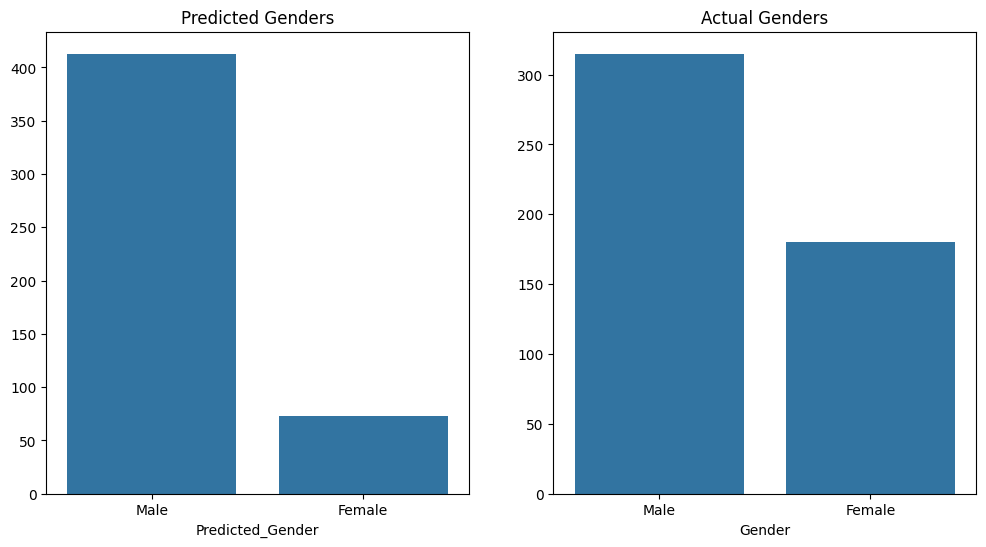

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' contains the DataFrame with columns 'Predicted_Gender' and 'Gender'
# Replace 'df' with the actual DataFrame name if different
# Replace 'Predicted_Gender' and 'Gender' with the actual column names if different

# Count the occurrences of predicted and actual genders
predicted_gender_counts = df['Predicted_Gender'].value_counts()
actual_gender_counts = df['Gender'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted genders
sns.barplot(x=predicted_gender_counts.index, y=predicted_gender_counts.values, ax=axes[0])
axes[0].set_title('Predicted Genders')

# Plot actual genders
sns.barplot(x=actual_gender_counts.index, y=actual_gender_counts.values, ax=axes[1])
axes[1].set_title('Actual Genders')

# Adjust layout to prevent overlap


# Show the plot
plt.show()


C:\Users\gauth\AppData\Local\Temp\ipykernel_34292\4158931325.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predicted_age_counts.index, y=predicted_age_counts.values, ax=axes[0], palette="muted")
C:\Users\gauth\AppData\Local\Temp\ipykernel_34292\4158931325.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actual_age_counts.index, y=actual_age_counts.values, ax=axes[1], palette="muted")


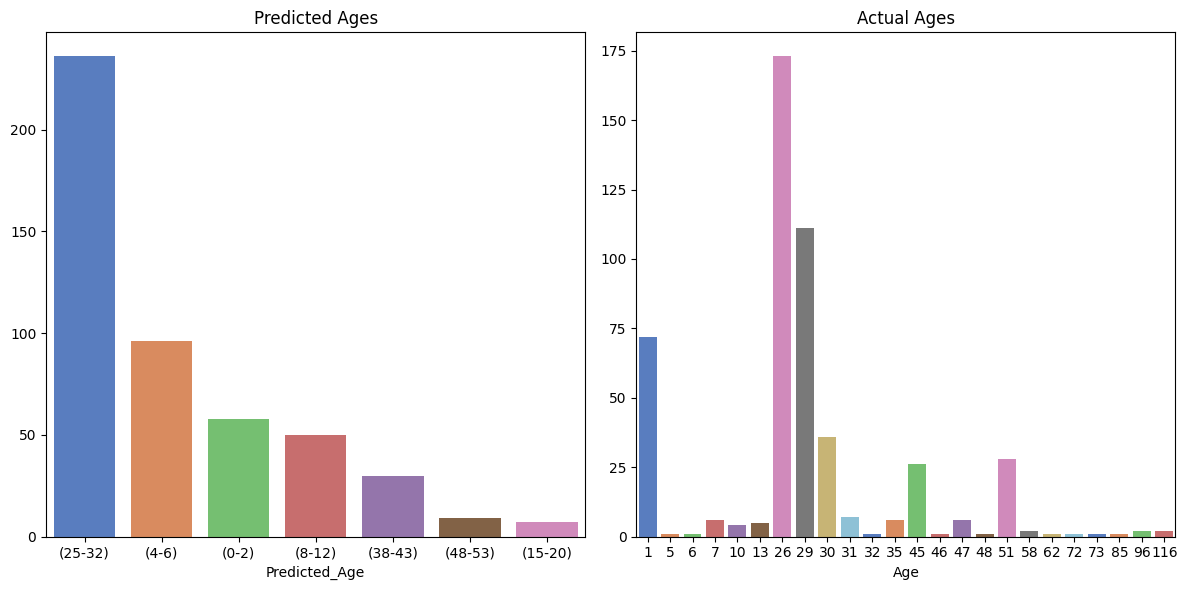

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of predicted and actual ages
predicted_age_counts = df['Predicted_Age'].value_counts()
actual_age_counts = df['Age'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted ages
sns.barplot(x=predicted_age_counts.index, y=predicted_age_counts.values, ax=axes[0], palette="muted")
axes[0].set_title('Predicted Ages')

# Plot actual ages
sns.barplot(x=actual_age_counts.index, y=actual_age_counts.values, ax=axes[1], palette="muted")
axes[1].set_title('Actual Ages')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


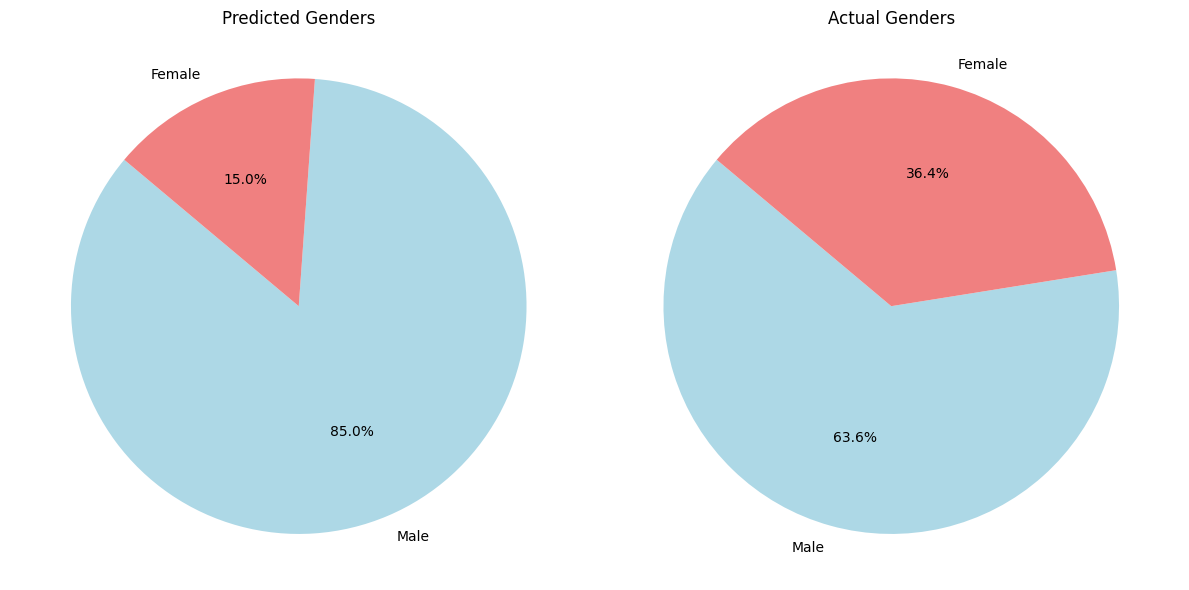

In [10]:


# Assuming 'df' contains the DataFrame with columns 'Predicted_Gender' and 'Gender'
# Replace 'df' with the actual DataFrame name if different
# Replace 'Predicted_Gender' and 'Gender' with the actual column names if different

# Count the occurrences of predicted and actual genders
predicted_gender_counts = df['Predicted_Gender'].value_counts()
actual_gender_counts = df['Gender'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a pie chart for predicted genders
axes[0].pie(predicted_gender_counts, labels=predicted_gender_counts.index, colors=['lightblue', 'lightcoral'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Predicted Genders')
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Create a pie chart for actual genders
axes[1].pie(actual_gender_counts, labels=actual_gender_counts.index, colors=['lightblue', 'lightcoral'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Actual Genders')
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


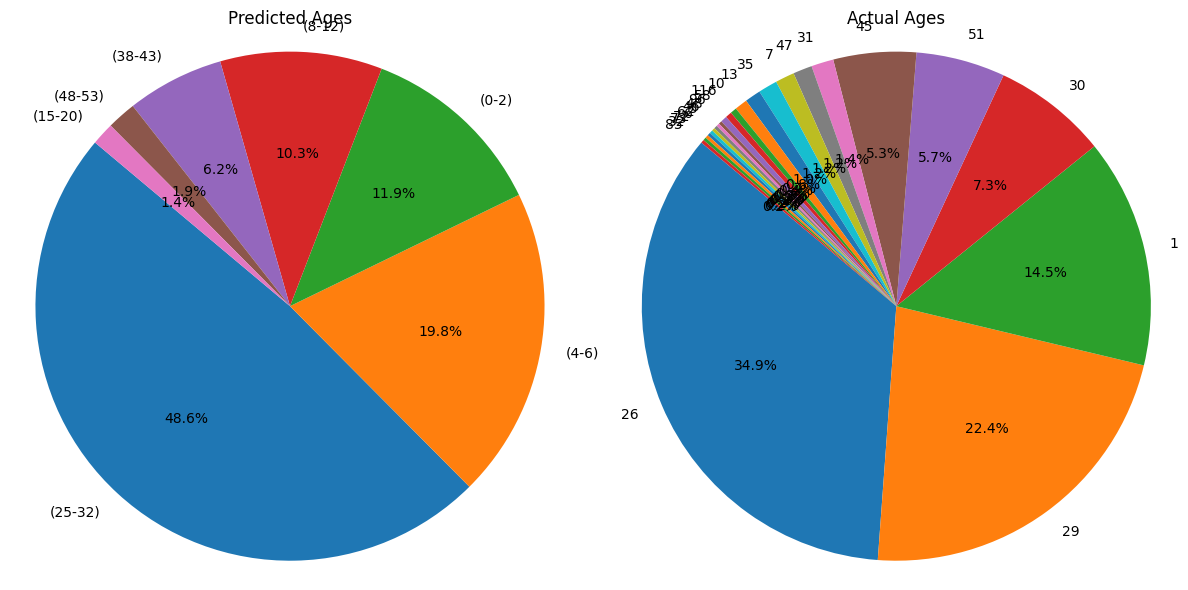

In [11]:
import matplotlib.pyplot as plt



# Create separate figures for ages
plt.figure(figsize=(12, 6))

# Plot pie chart for predicted ages
plt.subplot(1, 2, 1)
plt.pie(predicted_age_counts, labels=predicted_age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Predicted Ages')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Plot pie chart for actual ages
plt.subplot(1, 2, 2)
plt.pie(actual_age_counts, labels=actual_age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Actual Ages')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots for ages
plt.show()
